# MobileNet

<a id='top'.</a>
[Table of contents](#bot)

- [Initialization](#init)
- [Data augmentation](#da)
- [Modeling](#mod)
    - [Base model](#bm)
    - [Generating features](#gf)
    - [Top model](#tm)
    - [Setting alternative top models](#atm) 
    - [Training the whole model](#wm)
    - [Visualizing predictions](#pred)
    
[Table of contents](#top) [Bottom](#bot)
<a id='init'.</a>

## Initialization

In [22]:
import sys
sys.path.append('../utils/')

import libraries
from libraries import *
import utils_functions
from utils_functions import *

%matplotlib inline

reload(libraries)
from libraries import *
reload(utils_functions)
from utils_functions import *

# checking
print(get_available_gpus())
print(psutil.virtual_memory())
print(keras.__version__)

[]
svmem(total=17179869184, available=5877968896, percent=65.8, used=13597696000, free=2288267264, active=6027116544, inactive=3589701632, wired=3980877824)
2.0.8


#### Data loading

In [10]:
model = 'mobilenet'

# output directories
output = '../output'
models = 'models'
model_output = join(join(output, models), model)
model_output_weights = join(model_output, 'weights')

if not os.path.exists(output): os.mkdir(output)
if not os.path.exists(model_output): os.mkdir(model_output)
if not os.path.exists(model_output_weights): os.mkdir(model_output_weights)
    
# general variables
big_size = (512, 512)
target_size = (256, 256)
target_size_mn = (224, 224)
num_classes = 1
input_shape = target_size + (3,)
input_shape_mn = target_size_mn + (3,)

path='../../data/sushi_or_sandwich/'

In [11]:
x_train, y_train, x_test, y_test, mean_set, std_set = \
load_data(path=path, target_size=big_size, output_folder=output)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, mean_set, std_set)

Loading compressed data..
(640, 512, 512, 3) (640,) (160, 512, 512, 3) (160,) None None


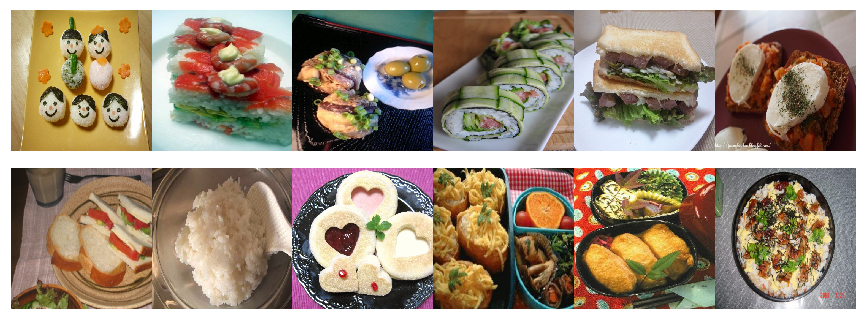

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]


In [12]:
plot_images(x_test[:12]); print(list(y_test[:6])); print(list(y_test[6:12]))

In [18]:
# output = 'test_data'
# if not os.path.exists(output): os.mkdir(output)

for _, (i, j) in enumerate(zip(x_test, y_test)):
#     print(i, j)
    if j == 0: 
        output = '../source/test_data/sandwich'
        plt.imsave(join(output, f'image_{_}.png'), i.astype(np.uint8), format='png')
    if j == 1: 
        output = '../source/test_data/sushi'
        plt.imsave(join(output, f'image_{_}.png'), i.astype(np.uint8), format='png')

In [24]:
import os
cwd = os.getcwd()

import sys
sys.path.append(cwd + '/src/utils/')
sys.path.append('../utils/')
print (sys.path)

import libraries
from libraries import *
import utils_functions
from utils_functions import *
reload(libraries)
from libraries import *
reload(utils_functions)
from utils_functions import *

def add_model_results(model, m, metrics):

    m_results = {}

    for _, i in enumerate(m.metrics_names):
        m_results[i] = metrics[_]

    results[model] = m_results

def print_results():

    print ("Evaluation metrics using the data contained @ //// \n")
    for i, j in results.items():
        for k, l in j.items(): print ("   %s: %.3f" %(k, l))

def evaluate_resnet_50():

    # directories
    model = 'resnet_50'
    model_output = join(join(output, models), model)
    model_output_weights = join(model_output, 'weights')

    ## base model
    bm = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    ## top model
    p = 0.8

    top_m = Sequential([
            BatchNormalization(input_shape=bm.output_shape[1:]),
            Flatten(),
            Dropout(p),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(p),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(p),
            Dense(1, activation='sigmoid')])

    ## whole model

    m = Model(bm.input, top_m(bm.output))

    m.compile(Adam(),
              loss='binary_crossentropy',
              metrics=metrics_list)

    m.load_weights(join(model_output_weights, 'm_0.2732_0.9000'))

    metrics = m.evaluate(x_test, y_test)

    add_model_results(model, m, metrics)

def evaluate_inception_v3():

    # directories
    model = 'inception_v3'
    model_output = join(join(output, models), model)
    model_output_weights = join(model_output, 'weights')

    ## base model
    bm = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

    ## top model
    p = 0.8

    top_m = Sequential([
            BatchNormalization(input_shape=bm.output_shape[1:]),
            MaxPooling2D(),
            Flatten(),
            Dropout(p),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(p),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(p),
            Dense(1, activation='sigmoid')])

    ## whole model

    m = Model(bm.input, top_m(bm.output))

    m.compile(Adam(),
              loss='binary_crossentropy',
              metrics=metrics_list)

    m.load_weights(join(model_output_weights, '.h5'))

    metrics = m.evaluate(x_test, y_test)

    add_model_results(model, m, metrics)

def evaluate_mobilenet():

    # reloading test data with the appropiate size
    
    x_test, y_test = load_test_data(target_size=target_size_mn)

    # directories
    model = 'mobilenet'
    model_output = join(join(output, models), model)
    model_output_weights = join(model_output, 'weights')

    ## base model
    bm = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape_mn)

    ## top model
    p = 0.8

    top_m = Sequential([
            BatchNormalization(input_shape=bm.output_shape[1:]),
            GlobalAveragePooling2D(),
            Dropout(p),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(p),
            Dense(1, activation='sigmoid')])

    ## whole model

    m = Model(bm.input, top_m(bm.output))

    m.compile(Adam(),
              loss='binary_crossentropy',
              metrics=metrics_list)

    m.load_weights(join(model_output_weights, 'm_p80_0.2221_0.9125'))

    metrics = m.evaluate(x_test, y_test)

    add_model_results(model, m, metrics)




if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='The script evaluates a \
                                     selection of models in terms of a set of selected metrics \
                                     -see optional arguments- using the data contained \
                                     under the "test_data" directory @ ../source/test_data. \n' \
                                     'If no options are provided all supported models \
                                     and a relevant set of metrics will be used.')

    # parser.add_argument('--nargs-int-type', nargs='+', type=int)
    parser.add_argument('--models', nargs='*', type=str, default=None, \
                        help='Models to evaluate. Options: resnet50, mobilenet, indeption_v3 ')
    parser.add_argument('--metrics', nargs='*', type=str, default=None, help='Metrics to use in \
    the model evaluation. Default: binary_crossentropy (loss), binary_accuracy, recall, precision, fmesure.')
    # parser.add_argument('--test_data_folder', type=bool, default=False)
    parser.add_argument('--from_dir', action="store_true", default=False, help='If True \
                         the test data will be read on batches from the "test_data"\
                         directory. This option is suitable when the size of the \
                         test set is relatively big and memory constraints may appear.')

#     p = parser.parse_args()
#     print(p.from_dir, p.metrics, p.models)
    # parser.print_help()

    # models to include

    models_list = ['resnet_50', 'mobilenet']

    # metrics to calculate

    metrics_list = [binary_accuracy,
                        recall,
                        precision,
                        fmeasure,
#                         fbeta_score,
#                         hinge,
#                         squared_hinge,
#                         kullback_leibler_divergence,
#                         poisson,
#                         cosine_proximity,
#                         matthews_correlation
                       ]

    # global variables
    target_size = (256, 256)
    target_size_mn = (224, 224)
    num_classes = 1
    input_shape = target_size + (3,)
    input_shape_mn = target_size_mn + (3,)
    results = {}

    # global directories
    output = '../output'
    models = 'models'

    # loading test data
    x_test, y_test = load_test_data(target_size=target_size)

    # model evaluation
    for i in models_list:
        exec('evaluate_{}()'.format(i))

        print_results()


['', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python36.zip', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/lib-dynload', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/extensions', '/Users/blanca_alonso/.ipython', '../utils/', '/Users/blanca_alonso/Documents/cookpad/git/checkpoint/src/nbs/src/utils/', '../utils/', '/Users/blanca_alonso/Documents/cookpad/git/checkpoint/src/nbs/src/utils/', '../utils/', '/Users/blanca_alonso/Documents/cookpad/git/checkpoint/src/nbs/src/utils/', '../utils/', '../utils/', '/Users/blanca_alonso/Documents/cookpad/git/checkpoint/src/nbs/src/utils/', '../utils/', '/Users/blanca_alonso/Documents/cookpad/git/checkpoint/src/nbs/src/utils/', '../utils/']
Loading compressed data..
160/160 [==============================] - 48s    
Evaluation metric